In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import gc 

In [2]:
workers = 4
batch_size = 4
image_size = 128
nc = 3
nz = 150
ngf = 128
ndf = 128
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [3]:
dataroot = "D:\Course Stuff\Kasai\RNN-GAN"
dataset = dset.ImageFolder(root=dataroot , transform = transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset , batch_size = 4 , shuffle = True)
#device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device = torch.device("cpu")


In [5]:
real_batch = next(iter(dataloader))

In [17]:
print(real_batch[0].size())
x = real_batch[0]

torch.Size([4, 3, 4352, 128])


In [18]:
y = x.view(4,3,34,128,128)
print(y.size())
z = y.permute(0,2,1,3,4)
print(z.size())
print(y[]
print(z

SyntaxError: invalid syntax (<ipython-input-18-08d4a7141105>, line 5)

In [4]:
class Conv_Gen(nn.Module):
    def __init__(self):
        super(Conv_Gen, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf , 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    
class Conv_Critic(nn.Module):
    def __init__(self):
        super(Conv_Critic, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2,affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4,affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8,affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16,affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 16, ndf, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input)

In [5]:
class RNN_Gen(nn.Module):
    def __init__(self):
        super(RNN_Gen, self).__init__()
        self.hidden_size = nz
        self.nc = 3
        self.batch_size = batch_size
        self.frame_count = 34
        self.pic_size = [128 , 128]
        self.ConvG = Conv_Gen()
        self.RNN = nn.LSTMCell(input_size = nz , hidden_size = nz)
        
        
    def forward(self , input , h0 , c0):
        latent = input
        hx = h0
        cx = c0
        out = torch.Tensor(self.frame_count , self.batch_size , self.nc , self.pic_size[0] , self.pic_size[1] )
        for i in range(self.frame_count):
            out[i] = self.ConvG(latent.view(self.batch_size,nz,1,1))
            hx , cx = self.RNN(latent , (hx,cx))
            latent = latent + hx
        out = out.permute(1,0,2,3,4)
        out = out.contiguous()
        return out
    
    
    
class RNN_Critic(nn.Module):
    def __init__(self):
        super(RNN_Critic, self).__init__()
        self.ConvC = Conv_Critic()
        self.RNN = nn.LSTM(input_size = 128 , hidden_size = 128 , num_layers = 1 , batch_first = True , bidirectional = True)
        self.out = nn.Sequential(
            nn.Linear(256 * 34 , 10 * 34, bias = True),
            nn.LeakyReLU(0.1, inplace = True),
            nn.Linear(10*34 , 10 , bias = True),
            nn.LeakyReLU(0.1, inplace = True),
            nn.Linear(10 , 1, bias = True),
            nn.Sigmoid()
        )
    def forward(self , input , hx , cx):
        rep = self.ConvC(input.view(batch_size*34,3,128,128))
        h , c = hx ,cx
        o , (hn, cn) = self.RNN(rep.view(batch_size,34,128), (h,c) )
        o = o.contiguous()
        return self.out(o.view(batch_size, 34*256))

In [20]:
z = torch.randn(batch_size, nz, device=device)
print(z.size())
print(ConvG(z.view(4,150,1,1)).size())
ConvC = Conv_Critic().to(device)
o1 = ConvG(z.view(4,150,1,1))
o2 = ConvC(o1)
o2.size()

torch.Size([4, 150])
torch.Size([4, 3, 128, 128])


torch.Size([4, 2048, 1, 1])

In [11]:
netD = RNN_Critic()
images = next(iter(dataloader))
images = images[0]
images = images.view(batch_size,3,34,128,128)
images = images.permute(0,2,1,3,4)
images = images.contiguous()
print(images.size())
print(images.view(4*34,3,128,128).size())
a = images
b = images.view(4*34,3,128,128)

torch.Size([4, 34, 3, 128, 128])
torch.Size([136, 3, 128, 128])


In [16]:
h0 = torch.zeros(2, batch_size, 128)
c0 = torch.zeros(2, batch_size, 128)
o = netD(images, h0 , c0)
print(o.size())

torch.Size([136, 128, 1, 1])
torch.Size([4, 1])


In [62]:
rnn = nn.LSTMCell(input_size = 10, hidden_size = 20)
input = torch.randn(6, 3, 10)
hx = torch.randn(3, 20)
cx = torch.randn(3, 20)
output = []
for i in range(6):
    hx, cx = rnn(input[i], (hx, cx))
    output.append(hx)
print(output[0].size())

torch.Size([3, 20])


In [13]:
netG = RNN_Gen(
ConvG = Conv_Gen()
z = torch.randn(batch_size, nz, device=device)

In [12]:
print(hg0.size())
o = netG(z , hg0 , cg0)
print(hg0.size())
o.size()

torch.Size([1, 4, 150])


RuntimeError: Input batch size 4 doesn't match hidden[0] batch size 1

In [60]:
netG = Conv_Gen().to(device)
netC = Conv_Critic().to(device)
out = netG(z)
o = netC(out)
print(o.size())

torch.Size([4, 1, 1, 1])


In [8]:
gc.collect()

7

In [6]:
netC = RNN_Critic().to(device)
netG = RNN_Gen().to(device)
real_label = 0.9
fake_label = 0.1
critic_iter = 5
lambda_term = 10
optimizerC = optim.Adam(netC.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [10]:
from torch.autograd import grad
from torch.autograd import Variable
img_list = []
G_losses = []
C_losses = []
iters = 0
num_epochs = 10
print("Starting Training Loop...")
# For each epoch
g_loss = torch.Tensor([0])
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, images in enumerate(dataloader, 0):
        
        step = epoch * len(dataloader) + i + 1
        netC.zero_grad()
        images = images[0].to(device)
        images = images.view(batch_size,3,34,128,128)
        images = images.permute(0,2,1,3,4)
        images = images.contiguous()
        if (images.size()[0] != batch_size):
                    continue
        z = torch.randn(batch_size, nz).to(device)
        hc0 = torch.zeros(2, batch_size, 128).to(device)
        cc0 = torch.zeros(2, batch_size, 128).to(device)
        c_loss_real = netC(images, hc0 , cc0)
        c_loss_real = c_loss_real.mean()
        hg0 = torch.zeros(batch_size, nz).to(device)
        cg0 = torch.zeros(batch_size, nz).to(device)
        fake_images = netG(z , hg0 , cg0)
        c_loss_fake = netC(fake_images , hc0 , cc0)
        c_loss_fake = c_loss_fake.mean()
        gc.collect()
        shape = [images.data.size(0)] + [1] * (images.data.dim() - 1)
        alpha = torch.rand(shape)
        inter = images.data + alpha * (fake_images.data - images.data)
        inter = Variable(inter, requires_grad=True).to(device)
        o = netC(inter , hc0 , cc0)
        gc.collect()
        g = grad(o, inter, grad_outputs=torch.ones(o.size()).to(device), create_graph=True , retain_graph=True)[0].view(z.size(0), -1)
        gp = ((g.norm(p=2, dim=1) - 1)**2).mean()
        c_loss = c_loss_fake - c_loss_real + lambda_term * gp
        c_loss.backward(retain_graph=True)
        optimizerC.step()
        gc.collect()
        if(step % critic_iter == 0):
            netG.zero_grad()
            netC.zero_grad()
            #z = torch.randn(batch_size, nz)
            z = Variable(torch.randn(batch_size, nz)).cuda(0)
            fake_images = netG(z , hg0 , cg0)
            g_loss = netC(fake_images , hc0 , cc0)
            g_loss = - g_loss.mean()   
            g_loss.backward()
            optimizerG.step()
        
        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     c_loss.item(), g_loss.item()))
        
        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        C_losses.append(c_loss.item())
            
        iters += 1

Starting Training Loop...


KeyboardInterrupt: 

In [11]:
hg0 = torch.zeros(batch_size, nz)
cg0 = torch.zeros(batch_size, nz)
z = torch.randn(batch_size, nz)
fake_images = netG(z , hg0 , cg0)
images = next(iter(dataloader))[0]
images = images.view(batch_size,3,34,128,128)
images = images.permute(0,2,1,3,4)
images = images.contiguous()
shape = [images.data.size(0)] + [1] * (images.data.dim() - 1)
alpha = torch.rand(shape)
print(images.size())
print(fake_images.size())
print(alpha.size())
inter = images.data + alpha * (fake_images.data - images.data)
inter = Variable(inter, requires_grad=True)

torch.Size([4, 34, 3, 128, 128])
torch.Size([4, 34, 3, 128, 128])
torch.Size([4, 1, 1, 1, 1])


NameError: name 'Variable' is not defined

In [7]:
# Training Loop

# Lists to keep track of progress
#img_list = []
G_losses = []
C_losses = []
#iters = 0
num_epochs = 20
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        netC.zero_grad()
        real_cpu = data[0].to(device)
        if (real_cpu.size()[0] != batch_size):
                    continue
        images = real_cpu.view(batch_size,3,34,128,128)
        images = images.permute(0,2,1,3,4)
        real_cpu = images.contiguous()
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        hc0 = torch.zeros(2, batch_size, 128).to(device)
        cc0 = torch.zeros(2, batch_size, 128).to(device)
        hg0 = torch.zeros(batch_size, nz).to(device)
        cg0 = torch.zeros(batch_size, nz).to(device)
        output = netC(real_cpu, hc0 , cc0 ).view(-1)
        errC_real = criterion(output, label)
        errC_real.backward()
        C_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        fake = netG(noise , hg0 , cg0)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netC(fake.detach(),hc0 , cc0).view(-1)
        # Calculate D's loss on the all-fake batch
        errC_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errC_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errC = errC_real + errC_fake
        # Update D
        optimizerC.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netC(fake,hc0 , cc0).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 5 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\n'
                  % (epoch, num_epochs, i, len(dataloader),
                     errC.item(), errG.item()))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        C_losses.append(errC.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        #if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
         #   with torch.no_grad():
          #      fake = netG(fixed_noise).detach().cpu()
           # img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        #iters +=

Starting Training Loop...
[0/20][0/13]	Loss_D: 1.4016	Loss_G: 0.8369

[0/20][5/13]	Loss_D: 0.6986	Loss_G: 2.1298

[0/20][10/13]	Loss_D: 0.6892	Loss_G: 2.2141

[1/20][0/13]	Loss_D: 0.6599	Loss_G: 2.1425

[1/20][5/13]	Loss_D: 0.6882	Loss_G: 2.1024

[1/20][10/13]	Loss_D: 0.6530	Loss_G: 2.1547

[2/20][0/13]	Loss_D: 1.4501	Loss_G: 2.4290

[2/20][5/13]	Loss_D: 0.6507	Loss_G: 2.1701

[2/20][10/13]	Loss_D: 0.6547	Loss_G: 1.8908

[3/20][0/13]	Loss_D: 0.6528	Loss_G: 2.0829

[3/20][5/13]	Loss_D: 0.6503	Loss_G: 2.0728

[3/20][10/13]	Loss_D: 0.6506	Loss_G: 2.0837

[4/20][0/13]	Loss_D: 0.6510	Loss_G: 2.1135

[4/20][5/13]	Loss_D: 0.6507	Loss_G: 2.0670

[4/20][10/13]	Loss_D: 1.0463	Loss_G: 2.1164

[5/20][0/13]	Loss_D: 0.6798	Loss_G: 1.9774

[5/20][5/13]	Loss_D: 0.6508	Loss_G: 2.0703

[5/20][10/13]	Loss_D: 0.6503	Loss_G: 2.0877

[6/20][0/13]	Loss_D: 0.6504	Loss_G: 2.1143

[6/20][5/13]	Loss_D: 0.7043	Loss_G: 2.0663

[6/20][10/13]	Loss_D: 0.6517	Loss_G: 2.1906

[7/20][0/13]	Loss_D: 2.3475	Loss_G: 0.8023


In [8]:
import pickle
pickle.dump(netG, open("RNN_gen_model", 'wb'))
pickle.dump(netC, open("RNN_dis_model", 'wb'))

In [9]:
fixed_noise = torch.randn(4, nz, device=device)
fake = netG(fixed_noise, hg0 , cg0)
fake_sample = fake[0]
fake_sample.size()
fake_sample = fake_sample.permute(1,0,2,3)
fake_sample = fake_sample.contiguous()
fake_sample = fake_sample.view(3,34*128,128)
fake_sample = fake_sample.contiguous()
fake_sample.size()

torch.Size([3, 4352, 128])

In [10]:
fake_sample = fake_sample.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


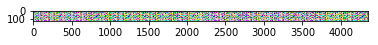

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.transpose(fake_sample))

torch.Size([4, 34, 3, 128, 128])

torch.Size([3, 4352, 128])


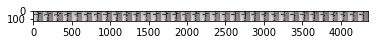

In [37]:
data = next(iter(dataloader))
real_cpu = data[0].to(device)
images = real_cpu.view(batch_size,3,34,128,128)
images = images.permute(0,2,1,3,4)
real_cpu = images.contiguous()
real_cpu.size()
fake_sample = real_cpu[0]
fake_sample.size()
fake_sample = fake_sample.permute(1,0,2,3)
fake_sample = fake_sample.contiguous()
fake_sample = fake_sample.view(3,34*128,128)
fake_sample = fake_sample.contiguous()
print(fake_sample.size())
fake_sample = fake_sample.detach().numpy()
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.transpose(fake_sample))

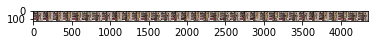

In [35]:
data = next(iter(dataloader))
real_cpu = data[0].to(device)
images = real_cpu.view(batch_size,3,34,128,128)
images = images.permute(0,2,1,3,4)
real_cpu = images.contiguous()
real_cpu.size()
fake_sample = real_cpu[0]
fake_sample = fake_sample.permute(1,0,2,3)
fake_sample = fake_sample.contiguous()
fake_sample = fake_sample.view(3,34*128,128)
fake_sample = fake_sample.contiguous()
fake_sample.size()
fake_sample = fake_sample.detach().numpy()
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.transpose(fake_sample))

In [38]:
from PIL import Image
im = Image.fromarray(np.transpose(fake_sample))
im.save("your_file.jpeg")

TypeError: Cannot handle this data type